<a href="https://colab.research.google.com/github/haeunkim48/Kaggle_transcription_learning/blob/main/Airport_traffic_visualization_geopandas_plotly.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Airport Traffic Visualization geopandas & Plotly

- Mainly explaining how to display the world map and how to plot the data using Geopandas.
- Creating plots of the ata on a world map by weekday and month using Geopandas.
- Elaborating how to use scatter_mapbox of Plotly, and create plot for mean of all traffic data by each airports.

In [ ]:
from datetime import date
import os

import geopandas as gpd
import geoplot as gplt
import folium
import mapclassify
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import plotly.express as px
import re
import seaborn as sns
from shapely.geometry import Point, Polygon
from shapely.geometry import MultiPolygon


## Data and library loading

In [ ]:
%matplotlib inline

In [ ]:
!ls ../input/covid19s-impact-on-airport-traffic/covid_impact_on_airport_traffic.csv

../input/covid19s-impact-on-airport-traffic/covid_impact_on_airport_traffic.csv


In [ ]:
covid_impact_on_airport_traffic = pd.read_csv("../input/covid19s-impact-on-airport-traffic/covid_impact_on_airport_traffic.csv")

In [ ]:
covid_impact_on_airport_traffic.head()

,AggregationMethod,Date,Version,AirportName,PercentOfBaseline,Centroid,City,State,ISO_3166_2,Country,Geography
0,Daily,2020-04-03,1.0,Kingsford Smith,64,POINT(151.180087713813 -33.9459774986125),Sydney,New South Wales,AU,Australia,"POLYGON((151.164354085922 -33.9301772341877, 1..."
1,Daily,2020-04-13,1.0,Kingsford Smith,29,POINT(151.180087713813 -33.9459774986125),Sydney,New South Wales,AU,Australia,"POLYGON((151.164354085922 -33.9301772341877, 1..."
2,Daily,2020-07-10,1.0,Kingsford Smith,54,POINT(151.180087713813 -33.9459774986125),Sydney,New South Wales,AU,Australia,"POLYGON((151.164354085922 -33.9301772341877, 1..."
3,Daily,2020-09-02,1.0,Kingsford Smith,18,POINT(151.180087713813 -33.9459774986125),Sydney,New South Wales,AU,Australia,"POLYGON((151.164354085922 -33.9301772341877, 1..."
4,Daily,2020-10-31,1.0,Kingsford Smith,22,POINT(151.180087713813 -33.9459774986125),Sydney,New South Wales,AU,Australia,"POLYGON((151.164354085922 -33.9301772341877, 1..."


## Following to Data description page, there are 11 columns.
- Aggregation Method: Aggregation period used to compute this metric.
- Date: Date Traffic volume measured, in format YYYY-MM-DD.
- Version: Version of this dataset
- AirportName: Name of airport
- Percent Of Baseline: Proportion of trips on this date as compared to Avg number of trips on the same day of week in baseline period ie. 1st Feb 2020 - 15th March 2020
- Centriod: Geography representing centroid of the Airport polygon
- City: City within which the Airport is located
- State: State within which the Airport is located
- ISO_3166_2: ISO-3166-2 code representing Country and Subdivision
- Country: Country within which the Airport is located
- Geography: Polygon of the Airport that is used to compute this metric


In [ ]:
covid_impact_on_airport_traffic.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7247 entries, 0 to 7246
Data columns (total 11 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   AggregationMethod  7247 non-null   object 
 1   Date               7247 non-null   object 
 2   Version            7247 non-null   float64
 3   AirportName        7247 non-null   object 
 4   PercentOfBaseline  7247 non-null   int64  
 5   Centroid           7247 non-null   object 
 6   City               7247 non-null   object 
 7   State              7247 non-null   object 
 8   ISO_3166_2         7247 non-null   object 
 9   Country            7247 non-null   object 
 10  Geography          7247 non-null   object 
dtypes: float64(1), int64(1), object(9)
memory usage: 622.9+ KB


## Preprocessing

- Changing data "Date" column -> data type

In [ ]:
covid_impact_on_airport_traffic["Date"] = pd.to_datetime(covid_impact_on_airport_traffic["Date"])

- Creating "weekday" columns, date, weekday () return 0 for Monday and 6 for Sunday


In [ ]:
covid_impact_on_airport_traffic["weekday"] = covid_impact_on_airport_traffic["Date"].map(lambda x: x.weekday())
w_list =  ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun']
covid_impact_on_airport_traffic["weekday"] = [w_list[idx] for idx in covid_impact_on_airport_traffic["weekday"]]

- Creating Latitude and longtitude columns. Centroid column has thoss data as Point Object but they are string -> cut out

In [ ]:
def cut_long(point):
    #point is like 'POINT(151.180087713813 -33.9459774986125)'
    long, _ = point[6:-1].split(" ")
    return float(long)

def cut_lat(point):
    #point is like 'POINT(151.180087713813 -33.9459774986125)'
    _, lat = point[6:-1].split(" ")
    return float(lat)

In [ ]:
covid_impact_on_airport_traffic["long"] = covid_impact_on_airport_traffic["Centroid"].map(cut_long)
covid_impact_on_airport_traffic["lat"] = covid_impact_on_airport_traffic["Centroid"].map(cut_lat)

- Dropping unnecessary columns

In [ ]:
need_columns = [col for col in covid_impact_on_airport_traffic.columns if not col in ["AggregationMethod", "Version", "Centroid"]]
covid_impact_on_airport_traffic = covid_impact_on_airport_traffic[need_columns]

In [ ]:
covid_impact_on_airport_traffic.head()

,Date,AirportName,PercentOfBaseline,City,State,ISO_3166_2,Country,Geography,weekday,long,lat
0,2020-04-03,Kingsford Smith,64,Sydney,New South Wales,AU,Australia,"POLYGON((151.164354085922 -33.9301772341877, 1...",Fri,151.180088,-33.945977
1,2020-04-13,Kingsford Smith,29,Sydney,New South Wales,AU,Australia,"POLYGON((151.164354085922 -33.9301772341877, 1...",Mon,151.180088,-33.945977
2,2020-07-10,Kingsford Smith,54,Sydney,New South Wales,AU,Australia,"POLYGON((151.164354085922 -33.9301772341877, 1...",Fri,151.180088,-33.945977
3,2020-09-02,Kingsford Smith,18,Sydney,New South Wales,AU,Australia,"POLYGON((151.164354085922 -33.9301772341877, 1...",Wed,151.180088,-33.945977
4,2020-10-31,Kingsford Smith,22,Sydney,New South Wales,AU,Australia,"POLYGON((151.164354085922 -33.9301772341877, 1...",Sat,151.180088,-33.945977


- Creating a supplemeentary data frame.

In [ ]:
covid_impact_on_airport_traffic_unique = covid_impact_on_airport_traffic[~covid_impact_on_airport_traffic[["AirportName"]].duplicated()].reset_index(drop=True)
covid_impact_on_airport_traffic_unique

,Date,AirportName,PercentOfBaseline,City,State,ISO_3166_2,Country,Geography,weekday,long,lat
0,2020-04-03,Kingsford Smith,64,Sydney,New South Wales,AU,Australia,"POLYGON((151.164354085922 -33.9301772341877, 1...",Fri,151.180088,-33.945977
1,2020-03-17,Santiago International Airport,72,Santiago,Santiago Province,CL,Chile,"POLYGON((-70.8043956756592 -33.3719683869737, ...",Tue,-70.794237,-33.390727
2,2020-04-05,Calgary International,65,Calgary,Alberta,CA-AB,Canada,"POLYGON((-113.981866836548 51.1392131913567, -...",Sun,-114.013123,51.118475
3,2020-04-20,Edmonton International,46,Leduc County,Alberta,CA-AB,Canada,"POLYGON((-113.568120002747 53.3110445425655, -...",Mon,-113.576261,53.308783
4,2020-05-15,Vancouver International,68,Richmond,British Columbia,CA-BC,Canada,"POLYGON((-123.136525154114 49.1980971490671, -...",Fri,-123.177541,49.193579
5,2020-05-27,Winnipeg International,100,Winnipeg,Manitoba,CA-MB,Canada,"POLYGON((-97.2094345092773 49.8979517850609, -...",Wed,-97.219062,49.902471
6,2020-03-29,Halifax International,32,Halifax,Nova Scotia,CA-NS,Canada,"POLYGON((-63.5266613960266 44.8984438169036, -...",Sun,-63.511672,44.883017
7,2020-04-10,Toronto Pearson,10,Mississauga,Ontario,CA-ON,Canada,"POLYGON((-79.6076846122742 43.6972621366144, -...",Fri,-79.631344,43.679352
8,2020-08-10,Hamilton International,100,Hamilton,Ontario,CA-ON,Canada,"POLYGON((-79.932746887207 43.1551600161937, -7...",Mon,-79.926693,43.172036
9,2020-09-16,Montreal Mirabel,100,Mirabel,Quebec,CA-QC,Canada,"POLYGON((-74.0895652770996 45.6856314730097, -...",Wed,-74.048380,45.681503


In [ ]:
df_geometry = covid_impact_on_airport_traffic_unique[['AirportName', 'City', 'State',
                                                     'ISO_3166_2', 'Country', 'long', 'lat']]

## Data Overview

- Finding where the airport is located(with folium, we can check the location no the interactive map)

In [ ]:
def visualize_airport_map(df, zoom):
    lat_map=30.038557
    lon_map=31.231781
    f = folium.Figure(width=1000, height=500)
    m = folium.Map([lat_map,lon_map], zoom_start=zoom).add_to(f)

    for i in range (0, len(df)):
        folium.Marker(location=[df["lat"][i],df["long"][i]],icon=folium.Icon(icon_color='white',icon ='plane',prefix='fa')).add_to(m)

    return m


In [ ]:
visualize_airport_map(covid_impact_on_airport_traffic_unique, 1)

Text(0.5, 1.0, 'records for each country')

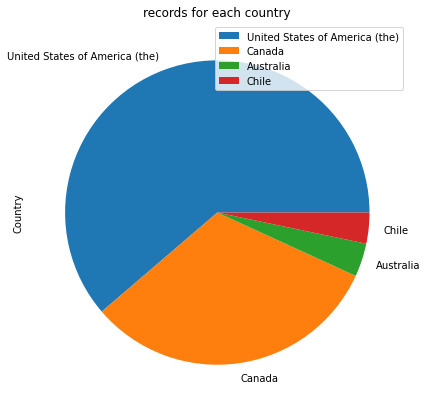

In [ ]:
df_Country_count = pd.DataFrame(covid_impact_on_airport_traffic["Country"].value_counts())
#df_Country_count
g = df_Country_count.plot.pie(y='Country', figsize=(7, 7))
g.set_title("records for each country")

- As a result, most of them are in North America.
- Counting the number of records per airport. The number of records at each airport is roughly the same

Text(0.5, 1.0, 'records for each airport')

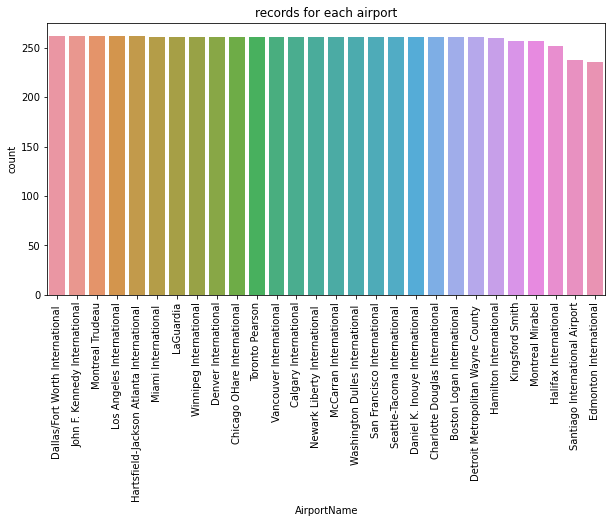

In [ ]:
plt.figure(figsize=(10, 5))
g = sns.countplot(data=covid_impact_on_airport_traffic, x="AirportName",
              order = covid_impact_on_airport_traffic['AirportName'].value_counts().index)
g.set_xticklabels(g.get_xticklabels(), rotation=90)
g.set_title("records for each airport")

- Counting the number of records per month

Text(0.5, 1.0, 'records for each month')

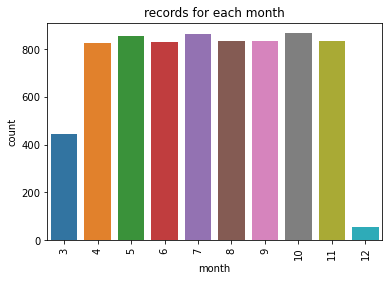

In [ ]:
df_month_count = pd.DataFrame(covid_impact_on_airport_traffic["Date"].map(lambda d: d.month).value_counts())
df_month_count = df_month_count.reset_index()
df_month_count = df_month_count.rename(columns={"Date":"count", "index":"month"})
g = sns.barplot(data=df_month_count.reset_index(), y="count", x="month")
g.set_xticklabels(g.get_xticklabels(), rotation=90)
g.set_title("records for each month")

- Checking the weekday rates.

Text(0.5, 1.0, 'records for each weekday')

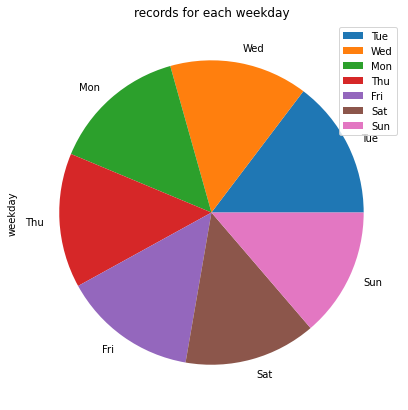

In [ ]:
df_weekday_count = pd.DataFrame (covid_impact_on_airport_traffic ["weekday"].value_counts())
g = df_weekday_count.plot.pie (y = 'weekday', figsize= (7,7))
g.set_title ("records for each weekday")

## Visualization with plotly

In [ ]:
df_airport_date_all_mean = covid_impact_on_airport_traffic.groupby(["AirportName"]).mean()
df_airport_date_all_mean = df_airport_date_all_mean.reset_index()

In [ ]:
df_airport_date_all_mean.head()

,AirportName,PercentOfBaseline,long,lat
0,Boston Logan International,64.704981,-71.010291,42.363633
1,Calgary International,89.513410,-114.013123,51.118475
2,Charlotte Douglas International,75.375479,-80.947811,35.213689
3,Chicago OHare International,73.084291,-87.910595,41.980460
4,Dallas/Fort Worth International,75.293893,-97.039498,32.894059


- visualize the following:


In [ ]:
fig = px.scatter_mapbox(df_airport_date_all_mean,
                        lat = "lat",
                        lon = "long",
                        hover_name = "AirportName",
                        hover_data = ["PercentOfBaseline"],
                        color = "PercentOfBaseline",
                        zoom =1,
                        height = 600,
                        size = "PercentOfBaseline",
                        size_max=30,
                        opacity = 0.4,
                        width = 1300)
fig.update_layout (mapbox_style = 'stamen - terrain')
fig.update_layout(margin={"r": 0, "t": 0, "l": 0, "b": 0})
fig.update_layout(title_text="Mean of trafic on sunday")
fig.show()
